# Pré-processamento dos dados

In [1]:
import pandas as pd
import numpy as np
from scipy import signal 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
columns_types = {'data':'category', 'estacao':'category','latitude':'object', 'longitude':'object', 'vento_zonal':np.float64, 
                 'vento_meridional':np.float64, 'temperatura':np.float64, 'temperatura_orvalho':np.float64 ,
                 'pressao_reduzida':np.float64 ,'precipitacao':np.float64}

df = pd.read_csv('./dados/T299x/2014/T299_2014_clean.csv', dtype=columns_types)
df.head()

,data,estacao,latitude,longitude,vento_zonal,vento_meridional,temperatura,temperatura_orvalho,pressao_reduzida,precipitacao
0,2014-01-01 00:00:00,13001,11.47,-23.0,-2.385,-5.073,20.288,14.147,1013.67,0.0
1,2014-01-01 06:00:00,13001,11.47,-23.0,-2.632,-4.503,20.684,16.142,1013.79,0.0
2,2014-01-01 12:00:00,13001,11.47,-23.0,-4.116,-5.625,21.565,17.618,1012.75,0.0
3,2014-01-01 18:00:00,13001,11.47,-23.0,-6.187,-4.209,22.429,17.321,1009.87,0.0
4,2014-01-02 00:00:00,13001,11.47,-23.0,-3.295,-2.950,23.307,16.578,1012.66,0.0


## Transformação dos dados

In [3]:
df.set_index(pd.DatetimeIndex(df['data']), inplace=True)
df.sort_index(inplace=True)
df.drop('data', axis=1, inplace=True)

### Hierarquia conceitual

Transformando os dados em um frequência diária, ou seja, uma observação por dia em cada estação, ao invés de quatro observações (a cada 6 horas).

In [4]:
df_sample = df.groupby(['estacao','latitude','longitude']).resample('D').mean()
df_sample.precipitacao = df.groupby(['estacao','latitude','longitude'])[['precipitacao']].resample('D').sum()
df = df_sample
df.tail()

vento_zonal  vento_meridional  \
estacao latitude longitude data                                        
SYCJ    6.5      -58.25    2014-12-27     -2.42125          -1.18900   
                           2014-12-28     -1.44150          -1.30950   
                           2014-12-29     -1.89675          -1.10675   
                           2014-12-30     -1.99275          -1.36400   
                           2014-12-31     -1.99400          -1.52400   

                                       temperatura  temperatura_orvalho  \
estacao latitude longitude data                                           
SYCJ    6.5      -58.25    2014-12-27     24.71025             22.90875   
                           2014-12-28     24.14950             22.45925   
                           2014-12-29     24.44250             22.60175   
                           2014-12-30     24.46775             22.60025   
                           2014-12-31     24.52250             22.32950   

                                       pressao_reduzida  precipitacao  
estacao latitude longitude data                                        
SYCJ    6.5      -58.25    2014-12-27         1011.8875       11.2240  
                           2014-12-28         1012.5300        9.5920  
                           2014-12-29         1012.4500       10.1015  
                           2014-12-30         1013.2025       16.6095  
                           2014-12-31         1012.9775       12.5995

### Alisamento (*smoothing*)

Filtro de mediana móveis **(*Moving Median*)**

In [5]:
df.temperatura = df.temperatura.groupby(level='estacao').transform(lambda x: signal.medfilt(x, kernel_size=31))
df.pressao_reduzida = df.pressao_reduzida.groupby(level='estacao').transform(lambda x: signal.medfilt(x, kernel_size=31))
df.vento_zonal = df.vento_zonal.groupby(level='estacao').transform(lambda x: signal.medfilt(x, kernel_size=31))
df.vento_meridional = df.vento_meridional.groupby(level='estacao').transform(lambda x: signal.medfilt(x, kernel_size=31))
df.temperatura_orvalho = df.temperatura_orvalho.groupby(level='estacao').transform(lambda x: signal.medfilt(x, kernel_size=31))
df.precipitacao = df.precipitacao.groupby(level='estacao').transform(lambda x: signal.medfilt(x, kernel_size=31))

Novamente a aplicação da técnica de **hierarquia conceitual** para separar a data em mês e dia

In [6]:
df.reset_index(inplace=True)
df.data = pd.to_datetime(df['data'])
df.insert(2, 'mes', df.data.dt.month)
df.insert(3, 'dia', df.data.dt.day)
df.drop('data', axis=1, inplace=True)
df[['mes','dia']] = df[['mes','dia']].astype('category')

In [7]:
df = df.round(1)
df.head()

,estacao,latitude,mes,dia,longitude,vento_zonal,vento_meridional,temperatura,temperatura_orvalho,pressao_reduzida,precipitacao
0,13001,11.47,1,1,-23.0,-2.5,-4.0,21.2,16.3,1011.5,0.0
1,13001,11.47,1,2,-23.0,-2.7,-4.2,21.7,16.9,1011.8,0.0
2,13001,11.47,1,3,-23.0,-2.8,-4.9,21.7,17.2,1012.1,0.0
3,13001,11.47,1,4,-23.0,-3.4,-4.9,21.7,17.3,1012.3,0.0
4,13001,11.47,1,5,-23.0,-3.7,-5.0,21.7,17.5,1012.5,0.0


In [8]:
assert df.isnull().values.sum() == 0

***Binning*** dos dados de precipitação e posterior categorização (adição da *Label* de classificação da precipitação). 

In [36]:
bins = [-1.,0.2,5.,25,2000]
group_names = ['sem chuva', 'chuva fraca', 'chuva moderada', 'chuva forte']
df['precipitacao_label'] = pd.cut(df.precipitacao, bins, labels=group_names)
#df['precipitacao_label'] = np.where(df.precipitacao > 0., 'com chuva', 'sem chuva')

print('---- Frequência das classes de chuva ----')
print(df.precipitacao_label.value_counts())

print('--- Percentual ---')
print(df.precipitacao_label.value_counts(normalize=True))

---- Frequência das classes de chuva ----
sem chuva         212597
chuva fraca       190129
chuva moderada     85690
chuva forte         2650
Name: precipitacao_label, dtype: int64
--- Percentual ---
sem chuva         0.432930
chuva fraca       0.387176
chuva moderada    0.174498
chuva forte       0.005396
Name: precipitacao_label, dtype: float64


A classe "sem chuva" representa aproximadamente 43% do total de classes

In [10]:
print('---- Intervalo de [0, 0.2] ----')
df[(df.precipitacao >= 0.) & (df.precipitacao <= 0.2)]['precipitacao_label'].unique().tolist()

---- Intervalo de [0, 0.2] ----


['sem chuva']

In [11]:
print('---- Intervalo de ]0.2, 5] ----')
df[(df.precipitacao > 0.2) & (df.precipitacao <= 5.)]['precipitacao_label'].unique().tolist()

---- Intervalo de ]0.2, 5] ----


['chuva fraca']

In [12]:
print('---- Intervalo de ]5, 25] ----')
df[(df.precipitacao > 5.) & (df.precipitacao <= 25.)]['precipitacao_label'].unique().tolist()

---- Intervalo de ]5, 25] ----


['chuva moderada']

In [13]:
print('---- Valores maiores que 25 ----')
df[df.precipitacao > 25.]['precipitacao_label'].unique().tolist()

---- Valores maiores que 25 ----


['chuva forte']

### Normalização Min-Max

Reduz o intervalo das variaveis de forma que elas estejam entre 0 e 1 (ou -1 a 1, se houver valores negativos).

In [14]:
df_norm = df.copy()
df_numeric = df.select_dtypes(include = ['float64'])
df_norm[df_numeric.columns] = MinMaxScaler().fit_transform(df_numeric)
df_norm.head()

,estacao,latitude,mes,dia,longitude,vento_zonal,vento_meridional,temperatura,temperatura_orvalho,pressao_reduzida,precipitacao,precipitacao_label
0,13001,11.47,1,1,-23.0,0.452830,0.321429,0.845272,0.861272,0.776627,0.0,sem chuva
1,13001,11.47,1,2,-23.0,0.445283,0.309524,0.852436,0.869942,0.781065,0.0,sem chuva
2,13001,11.47,1,3,-23.0,0.441509,0.267857,0.852436,0.874277,0.785503,0.0,sem chuva
3,13001,11.47,1,4,-23.0,0.418868,0.267857,0.852436,0.875723,0.788462,0.0,sem chuva
4,13001,11.47,1,5,-23.0,0.407547,0.261905,0.852436,0.878613,0.791420,0.0,sem chuva


Os atributos que foram tratados com a técnica de hierarquia conceitual foram representados de forma binária a partir de n atributos, um para cada possível valor dos atributos

### Representação Binária dos atributos

#### One-Hot Encoding

In [15]:
#df_norm = pd.concat([df_norm, pd.get_dummies(df_norm.precipitacao_label)],axis=1)
#df_norm.drop('precipitacao_label', axis=1, inplace=True)
#df_norm.head()

#### Label Encoding

In [16]:
labels, levels = pd.factorize(df_norm.precipitacao_label)
df_norm.precipitacao_label = labels

labels, levels = pd.factorize(df_norm.estacao)
df_norm.estacao = labels
df_norm.head()

,estacao,latitude,mes,dia,longitude,vento_zonal,vento_meridional,temperatura,temperatura_orvalho,pressao_reduzida,precipitacao,precipitacao_label
0,0,11.47,1,1,-23.0,0.452830,0.321429,0.845272,0.861272,0.776627,0.0,0
1,0,11.47,1,2,-23.0,0.445283,0.309524,0.852436,0.869942,0.781065,0.0,0
2,0,11.47,1,3,-23.0,0.441509,0.267857,0.852436,0.874277,0.785503,0.0,0
3,0,11.47,1,4,-23.0,0.418868,0.267857,0.852436,0.875723,0.788462,0.0,0
4,0,11.47,1,5,-23.0,0.407547,0.261905,0.852436,0.878613,0.791420,0.0,0


## Redução dos dados

### Filtragem por domínio

Para garantir o balanceamento em relação a quantidade de dados para cada estação, foram retirados do conjunto de dados as estações que possuiam menos de 350 dados dentre os 365 que deveriam existir para cada dia do ano

In [17]:
def percentual(total_geral, total_analisado, texto):
    print(texto + ': {0:.2f}'.format((total_analisado * 100)/total_geral)+'%')

In [18]:
df_norm.estacao.value_counts()
total_estacao = df_norm.estacao.value_counts().count()
sr_estacao = df_norm.estacao.value_counts() < 360
estacao_remover = sr_estacao[sr_estacao]
percentual(total_estacao, estacao_remover.count(), 'Percentual de estações removidas')

Percentual de estações removidas: 2.56%


In [19]:
total_registros = df_norm.shape[0]
registros_estacao_remover = df_norm[df_norm.groupby('estacao')['estacao'].transform('size') < 360].shape[0]
percentual(total_registros, registros_estacao_remover, 'Percentual de registros removidos')

Percentual de registros removidos: 0.92%


In [20]:
df_filter = df_norm[~df_norm.estacao.isin(estacao_remover.index)].copy()
#df_norm.groupby('estacao').filter(lambda x: len(x) > 360)

In [21]:
df_filter.shape

(486545, 12)

In [22]:
df_filter[['latitude','longitude']] = df_filter[['latitude','longitude']].astype('float64')
lat = (df_filter.latitude >= -32.) & (df_filter.latitude <= 5.8)
lon = (df_filter.longitude >= -73.) & (df_filter.longitude <= -33.)
df_brasil = df_filter[(lat) & (lon)].copy()

percentual(df_filter.shape[0], df_brasil.shape[0], 'Percentual de registros mantidos')

Percentual de registros mantidos: 75.17%


In [23]:
df_brasil.shape

(365730, 12)

### Seleção de atributo

#### Seleção de Atributos baseada em Correlação

Remoção de atributos reduntantes ou altamente correlacionados

In [24]:
df_brasil.drop(['latitude','longitude','precipitacao'], axis=1, inplace=True)
df_brasil.head()

,estacao,mes,dia,vento_zonal,vento_meridional,temperatura,temperatura_orvalho,pressao_reduzida,precipitacao_label
5110,14,1,1,0.54717,0.529762,0.869628,0.916185,0.758876,0
5111,14,1,2,0.54717,0.494048,0.873926,0.919075,0.758876,0
5112,14,1,3,0.54717,0.434524,0.878223,0.919075,0.770710,0
5113,14,1,4,0.54717,0.398810,0.878223,0.919075,0.807692,0
5114,14,1,5,0.54717,0.375000,0.881089,0.921965,0.815089,0


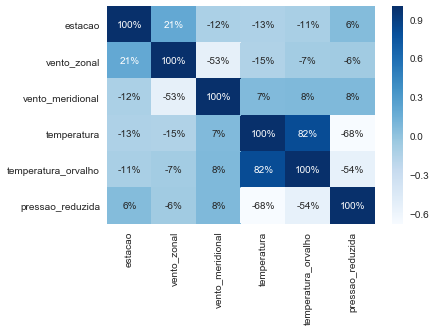

In [25]:
df_features = df_brasil.iloc[:,:8]
sns.heatmap(df_features.corr(), annot=True, cmap='Blues', fmt='.0%')

In [26]:
df_brasil.drop(['temperatura_orvalho'], axis=1, inplace=True)

###  Amostragem estratificada

Mantem a mesma proporção entre as classes existentes no conjunto de dados original

In [27]:
X = df_brasil.iloc[:,:7].values
y = df_brasil.iloc[:,7:11].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [29]:
df_y = pd.DataFrame(y_train, columns=['classes'])
df_y.classes = df_y.classes.map({0:'sem chuva', 1:'chuva fraca', 2:'chuva moderada', 3:'chuva forte'})

print('---- Frequência das classes de chuva ----')
print(df_y.classes.value_counts())

print('--- Percentual---')
print(df_y.classes.value_counts(normalize=True))
#df_y = pd.DataFrame(y_train, columns=['sem chuva', 'chuva fraca', 'chuva moderada', 'chuva forte'])
#df_y.sum()

---- Frequência das classes de chuva ----
sem chuva         126778
chuva fraca       111980
chuva moderada     53757
chuva forte           69
Name: classes, dtype: int64
--- Percentual---
sem chuva         0.433305
chuva fraca       0.382728
chuva moderada    0.183732
chuva forte       0.000236
Name: classes, dtype: float64


Após a estratificação, a classe "sem chuva" continua a representar aproximadamente 43% do total de classes

## Balanceamento dos dados

SMOTE é um método de balanceamento de dados que gera tuplas sintéticas da classe minoritária no conjunto de dados. Deve ser feita apenas nos dados de treinamento.

In [30]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train.flatten())

In [31]:
df_y = pd.DataFrame(y_train, columns=['classes'])
df_y.classes = df_y.classes.map({0:'sem chuva', 1:'chuva fraca', 2:'chuva moderada', 3:'chuva forte'})
df_y.classes.value_counts()

chuva fraca       126778
chuva forte       126778
sem chuva         126778
chuva moderada    126778
Name: classes, dtype: int64

In [32]:
np.savetxt('./dados/X_train.csv', X_train, delimiter=",", fmt='%g')

In [33]:
np.savetxt('./dados/y_train.csv', y_train, delimiter=",", fmt='%g')

In [34]:
np.savetxt('./dados/X_test.csv', X_test, delimiter=",", fmt='%g')

In [35]:
np.savetxt('./dados/y_test.csv', y_test, delimiter=",", fmt='%g')